In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import pairwise_distances

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [2]:
def read_xy(x_fp, y_fp):
    x = pd.read_csv(x_fp, header=None, index_col=0)
    y = pd.read_csv(y_fp, index_col=0)
    return {'x': x, 'y': y}

In [3]:
def count_y_class(y_df):
    y_class = y_df.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    # y_class.head(2)
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    return y_class2num

In [4]:
def predict_y(x, model):
    y_pred_raw = model.predict(x)
    y_pred_bool = tf.math.sigmoid(y_pred_raw)
    y_pred_bool = y_pred_bool.numpy()
    y_pred_bool[y_pred_bool >= 0.5] = 1
    y_pred_bool[y_pred_bool < 0.5] = 0
    return y_pred_bool

In [5]:
def predict_y_reg(x, model):
    y_pred_raw = model.predict(x)
    y_pred_int = np.rint(y_pred_raw)
    return y_pred_int.astype(np.int)

In [6]:
def count_pred_error_in_class(y, y_pred):
    pred_comp_bool = np.all(y == y_pred, axis=1)
    y_pred_error = y_pred[~pred_comp_bool]
    y_class = y.apply(lambda x: ''.join([str(i) for i in x]), axis=1).to_frame(name='class')
    y_pred_error_count_by_class = y_class.loc[y_class.index.isin(y_pred_error.index), 'class'].value_counts().to_frame(name='n_error')
    
    y_class2num = y_class['class'].value_counts().to_frame(name='num')
    y_class2num['n_error'] = 0
    y_class2num.loc[y_pred_error_count_by_class.index, 'n_error'] = y_pred_error_count_by_class.n_error
    return y_class2num

In [7]:
model = keras.models.load_model('../big-data/moses_dataset/nn/tandem/model_reg.h5')

In [8]:
xy_train = read_xy(x_fp='../big-data/moses_dataset/nn/tandem/x_training_set_mol2vec.csv', 
                                       y_fp='../big-data/moses_dataset/nn/tandem/y_train_regression.csv')
x_train = xy_train['x']
y_train = xy_train['y']

In [9]:
x_train.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id6,1.721,37.048,8.063,39.479,11.914,10.657,27.576,6.206,21.575,-14.910,...,4.279,17.046,17.669,-20.635,-10.251,-11.974,0.291,-23.474,20.828,5.790
id8,7.692,44.101,-3.271,41.178,8.850,7.428,39.477,16.484,9.422,-10.255,...,7.549,23.413,27.364,-23.395,-6.581,-4.571,1.686,-42.989,13.866,-0.857


In [10]:
y_train.head(5)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1,0,4,1,1,0,1,1
id8,0,0,5,0,1,0,2,0
id11,0,0,5,0,1,0,1,0
id17,1,0,3,0,2,0,0,2
id24,5,0,1,3,0,0,3,0


In [11]:
y_train_bool = y_train.copy()
y_train_bool[y_train >= 1] = 1

In [12]:
y_train_class2num = count_y_class(y_df=y_train_bool)
print(y_train_class2num.shape)
y_train_class2num.head(2)

(98, 2)


,num,n_error
11111011,4500,0
11100011,4500,0


In [13]:
y_train_pred_int = predict_y_reg(model=model, x=x_train)
y_train_pred = pd.DataFrame(data=y_train_pred_int, index=y_train.index, columns=y_train.columns)
y_train_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id6,1,0,3,1,1,0,1,1
id8,0,0,5,0,1,0,2,0


In [14]:
y_train_pred_bool = y_train_pred.copy()
y_train_pred_bool[y_train_pred >= 1] = 1
y_train_class2num2 = count_pred_error_in_class(y=y_train_bool, y_pred=y_train_pred_bool)
y_train_class2num2.head(2)

,num,n_error
11111011,4500,190
11100011,4500,200


In [15]:
y_train_class2num2.sum()

num        155970
n_error     10041
dtype: int64

In [16]:
1-10041/155970

0.935622235045201

### test

In [17]:
xy_test = read_xy(x_fp='../big-data/moses_dataset/nn/tandem/x_test_set_mol2vec.csv', 
                                     y_fp='../big-data/moses_dataset/nn/tandem/y_test_regression.csv')
x_test = xy_test['x']
y_test = xy_test['y']

In [18]:
x_test.head(2)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
id27,3.363,43.846,5.281,47.272,16.325,9.205,37.772,12.709,19.836,-10.396,...,4.132,22.226,24.857,-24.497,-10.268,-9.396,1.144,-31.732,20.651,3.809
id39,1.674,27.161,10.012,38.026,10.756,10.680,23.919,1.463,21.048,-9.700,...,1.453,16.444,13.976,-17.394,-10.040,-14.880,-5.086,-11.914,23.642,5.947


In [19]:
y_test.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,2,1,2,1


In [20]:
y_test_pred = predict_y_reg(x=x_test, model=model)
y_test_pred = pd.DataFrame(data=y_test_pred, index=y_test.index, columns=y_test.columns)
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,1,1,3,0


In [21]:
y_test_pred.head(2)

,nN,nS,nO,nX,nBondsD,nBondsT,naRing,nARing
0,,,,,,,,
id27,0,0,4,0,2,0,2,0
id39,2,0,2,0,1,1,3,0


In [22]:
y_test_bool = y_test.copy()
y_test_pred_bool = y_test_pred.copy()
y_test_bool[y_test >= 1] = 1
y_test_pred_bool[y_test_pred >= 1] = 1
y_test_class2num = count_pred_error_in_class(y=y_test_bool, y_pred=y_test_pred_bool)
y_test_class2num.head()

,num,n_error
10101010,5000,803
10101111,5000,531
11101010,5000,1421
10111111,5000,593
11000011,3826,133


In [23]:
y_test_class2num.sum()

num        48207
n_error     5924
dtype: int64

In [25]:
7821 / 48207, 6818 / 48207, 1-2978/48207, 1-5927/48207

(0.16223784927500157,
 0.14143174227809238,
 0.9382247391457672,
 0.8770510506772875)

In [26]:
y_test_class2num['class_in_train'] = 0
y_test_class2num.loc[y_test_class2num.index.isin(y_train_class2num2.index), 'class_in_train'] = 1

In [27]:
y_test_class2num['accuray_in_each_class'] = 1 - y_test_class2num['n_error'] / y_test_class2num['num']

In [28]:
y_test_class2num.head()

,num,n_error,class_in_train,accuray_in_each_class
10101010,5000,803,0,0.839400
10101111,5000,531,0,0.893800
11101010,5000,1421,0,0.715800
10111111,5000,593,0,0.881400
11000011,3826,133,0,0.965238


In [29]:
y_test_class2num.to_csv('../big-data/moses_dataset/nn/tandem/y_test_class2num_reg.csv')

### embedding vector

In [30]:
m_part1 = keras.models.load_model('../big-data/moses_dataset/nn/tandem/m_part1_reg.h5')
m_part1

In [31]:
x_train_test = x_train.append(x_test)
x_train_test.shape

(204177, 100)

In [32]:
x_embedding = m_part1.predict(x_train_test)
type(x_embedding)

numpy.ndarray

In [33]:
x_embedding = pd.DataFrame(data=x_embedding, index=x_train_test.index)
x_embedding.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,
id6,-1.758095,-1.314238,-1.748552,0.828552,16.262810,-1.464876,-1.132893,2.342188,-1.131331,-1.758088,...,-1.758099,11.693974,11.799228,0.713370,4.440019,-1.758099,10.347480,-1.220067,-1.138222,-1.367908
id8,-1.758067,-1.751353,-1.488015,-1.667771,33.258125,4.441078,-1.239757,8.775445,-1.757985,1.727221,...,-1.758099,2.490234,8.326378,0.440066,-0.614196,-1.758099,-0.970247,2.732983,-1.758040,9.311937


##### fragment embedding

In [34]:
frag2vec = pd.read_csv('../big-data/moses_dataset/best_model/sub_ws_10_minn_1_maxn_2_tandem/frag2vec_ws_10_minn_1_maxn_2.csv', 
                                                  index_col='fragment')
frag2vec.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
fragment,,,,,,,,,,,,,,,,,,,,,
CC,-0.253007,2.814439,0.631465,3.91316,2.040925,0.796896,2.661940,0.021895,2.529243,-1.402341,...,-0.245016,1.609034,1.936470,-1.688744,-1.291837,-1.429601,-0.237054,-1.588405,2.023266,0.621825
CN,-1.200405,2.818627,1.670609,4.04149,0.775769,1.403563,2.107731,-0.174444,3.458979,-1.389063,...,1.237666,0.373404,1.390743,-2.079343,-1.213773,-1.414402,-0.730551,-1.246170,2.562797,1.275736


In [35]:
frag_embedding = m_part1.predict(frag2vec)
frag_embedding_df = pd.DataFrame(data=frag_embedding, index=frag2vec.index)
frag_embedding_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
fragment,,,,,,,,,,,,,,,,,,,,,
CC,-1.398646,2.064460,-1.740268,6.175071,-1.640423,-1.751919,-1.740276,-1.447739,-1.757515,-1.740159,...,1.679565,-1.677368,-1.133195,1.465220,5.931867,-1.028342,-1.743952,-1.700746,-1.755964,-0.505345
CN,-1.414504,1.631308,-1.744732,8.029119,-1.650811,-1.757558,-1.671416,-0.943040,-1.756576,-1.709462,...,0.904102,-1.524127,-0.753304,2.480434,5.852436,-1.611341,-1.751398,-0.785844,-1.736401,-1.744110


In [36]:
frag_embedding_df.to_csv('../big-data/moses_dataset/nn/tandem/frag_embedding_reg.csv')

In [37]:
cid2smiles = pd.read_csv('../big-data/moses_dataset/result/mol2md_with_cid.csv', index_col='cid', usecols=['smiles', 'cid'])
cid2smiles.head(2)

,smiles
cid,
id2,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
id3,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [38]:
cid2smiles.loc[x_embedding.index, ['smiles']].to_csv('../big-data/moses_dataset/nn/tandem/cid2smiles_all_in_train_test.csv')

In [39]:
x_embedding2 = x_embedding.copy()
x_embedding2['smiles'] = cid2smiles.loc[x_embedding.index, 'smiles']
x_embedding2.set_index('smiles', inplace=True)
# x_embedding.drop(columns='cid', inplace=True)
x_embedding2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
smiles,,,,,,,,,,,,,,,,,,,,,
CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,-1.758095,-1.314238,-1.748552,0.828552,16.262810,-1.464876,-1.132893,2.342188,-1.131331,-1.758088,...,-1.758099,11.693974,11.799228,0.713370,4.440019,-1.758099,10.347480,-1.220067,-1.138222,-1.367908
COc1ccccc1OC(=O)Oc1ccccc1OC,-1.758067,-1.751353,-1.488015,-1.667771,33.258125,4.441078,-1.239757,8.775445,-1.757985,1.727221,...,-1.758099,2.490234,8.326378,0.440066,-0.614196,-1.758099,-0.970247,2.732983,-1.758040,9.311937


In [40]:
x_embedding2.iloc[9, :].name

'Cc1cc(Cc2cnc(N)nc2N)c2cccnc2c1N(C)C'

In [41]:
def cal_distance(x, y, metric='euclidean'):
    if type(x) == pd.core.series.Series:
        x = x.values.reshape(1, -1)
    if type(y) == pd.core.series.Series:
        y = y.values.reshape(1, -1)
    return pairwise_distances(x, y, metric=metric)

In [52]:
def print_closest_words(x_embedding, x_query, n=5, add_vec=None):
    x = x_embedding.loc[x_query].values.reshape(1, -1).copy()
    # print('x is: {}'.format(x))
    if add_vec is not None:
        x += add_vec
        # print('x + add_vec is: {}'.format(x))
    dists = cal_distance(x=x_embedding.values, y=x)     # compute distances to all words
    lst = sorted(enumerate(dists), key=lambda x: x[1]) # sort by distance
    # print(lst[:100])
    all_smiles = []
    all_dis = [] 
    if add_vec is not None:
        for idx, difference in lst[0:n]:
            _smiles = x_embedding.iloc[idx,:].name
            all_smiles.append(_smiles)
            all_dis.append(difference[0])
            print(_smiles, difference)
    else:
        for idx, difference in lst[1:n+1]:   # take the top n
            _smiles = x_embedding.iloc[idx,:].name
            all_smiles.append(_smiles)
            all_dis.append(difference[0])
            print(_smiles, difference)
    return {'smiles': all_smiles, 'dis': all_dis}

In [43]:
def get_minus_result(x_embedding, x, y):
    x = x_embedding.loc[x].values.reshape(1, -1)
    y = x_embedding.loc[y].values.reshape(1, -1)
    return x-y

In [44]:
def draw_mol_by_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    size = (200, 200)
    return Draw.MolToImage(mol, size=size)

In [45]:
mol1 = x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC']
mol2 = x_embedding2.loc['CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O']
# mol1 = mol1.values.reshape(-1,1)
# print(mol1.shape, type(mol1))
# print(type(mol1) == pd.core.series.Series)
cal_distance(mol1, mol2)

array([[41.040882]], dtype=float32)

In [66]:
def draw_multiple_mol(smiles_list, mols_per_row=4, file_path=None, legends=None):
    mols = []
    for i in smiles_list:
        mols.append(Chem.MolFromSmiles(i))
    mols_per_row = min(len(smiles_list), mols_per_row)
    if legends is None:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(260, 150), useSVG=True)
    else:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(260, 150), useSVG=True, legends=legends)
    if file_path:
        with open(file_path, 'w') as f_handle:
            f_handle.write(img.data)
    return img

In [46]:
ch2 = get_minus_result(x_embedding2, 'COc1cccc(COC(=O)c2cccc(OC)c2O)c1', 'COc1ccccc1OC(=O)Oc1ccccc1OC')
ch2

array([[-1.3113022e-06, -7.5936317e-04, -6.6109896e-03, -5.4397464e-02,
        -2.5176353e+00, -1.7289414e+00, -3.1524038e-01, -1.3670053e+00,
        -3.9815903e-05, -2.9150500e+00, -2.3982620e+00, -3.2219772e+00,
        -8.3880424e-02, -2.6911545e-01,  1.8239021e-05,  3.5986936e-01,
        -1.1336787e+00,  0.0000000e+00, -1.4948845e-04, -2.4003971e+00,
         0.0000000e+00,  4.9464059e-01, -2.3421774e+00, -6.6181421e-01,
         1.1136141e+00,  0.0000000e+00,  4.1566563e-01, -5.6467390e-01,
        -5.9604645e-06, -1.8138547e+00]], dtype=float32)

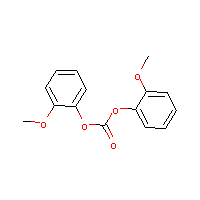

In [48]:
draw_mol_by_smiles('COc1ccccc1OC(=O)Oc1ccccc1OC')

In [50]:
x_embedding2.loc['COc1ccccc1OC(=O)Oc1ccccc1OC'].values.reshape(1,-1)

array([[-1.7580671, -1.7513533, -1.4880153, -1.6677711, 33.258125 ,
         4.4410777, -1.2397566,  8.775445 , -1.7579846,  1.7272214,
        22.775188 , 39.534874 ,  9.963957 ,  9.156121 , -1.7579857,
         0.8940164,  5.093331 , -1.7580993, -1.7578458,  4.9059596,
        -1.7580993,  2.4902344,  8.326378 ,  0.4400661, -0.6141958,
        -1.7580993, -0.9702471,  2.732983 , -1.7580401,  9.311937 ]],
      dtype=float32)

In [70]:
nearest_neigh_1 = print_closest_words(x_embedding=x_embedding2, x_query='COc1ccccc1OC(=O)Oc1ccccc1OC', n=8)
# nearest_neigh_1 = []

COc1ccc(OCC(=O)Oc2ccc(OC)cc2)cc1 [2.1388276]
COc1ccc(OC(=O)COc2ccccc2OC)cc1 [2.1388276]
COc1ccccc1OCC(=O)Oc1ccccc1OC [2.1388276]
COc1ccc(OC(=O)COc2cccc(OC)c2)cc1 [2.1388276]
COc1cc(OC)c(C(=O)OCc2ccccc2)cc1OC [4.313723]
COC(=O)c1cc(OC)c(OC)c(OCc2ccccc2)c1 [4.313723]
COc1ccc(C(=O)c2ccc(OC)c(OC)c2OC)cc1 [4.313723]
COc1cc(C(=O)OCc2ccccc2)cc(OC)c1OC [4.313723]


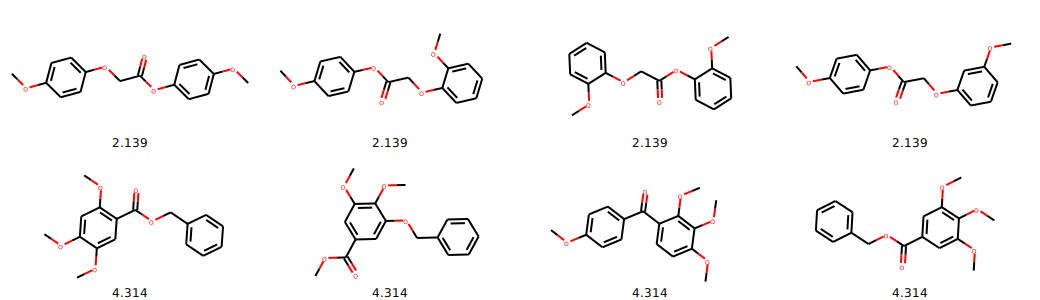

In [71]:
draw_multiple_mol(smiles_list=nearest_neigh_1['smiles'], legends=[str('{:.3f}'.format(i)) for i in nearest_neigh_1['dis']])

In [72]:
nn2 = print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O', n=8)

COC(=O)c1cc(Br)c(O)c(Br)c1 [0.]
COC(=O)Cc1cc(Br)c(O)c(Br)c1 [1.7914381]
CCOC(=O)c1c(O)cc(Br)cc1F [3.2090201]
COC(=O)C(O)c1cc(Br)ccc1F [3.525954]
COC(=O)C(O)c1ccc(F)c(Br)c1 [3.525954]
COC(=O)CCc1cc(Br)c(O)c(Br)c1 [3.6800902]
CCOC(=O)C(O)c1cc(Br)ccc1F [3.6805036]
CCOC(=O)C(O)c1cccc(Br)c1F [3.680505]


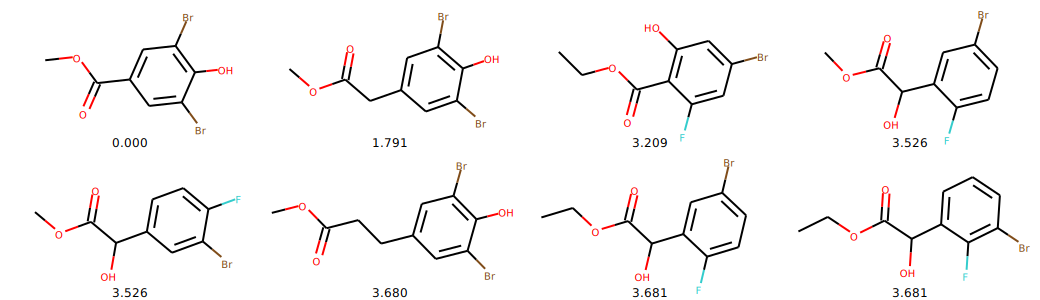

In [73]:
draw_multiple_mol(smiles_list=nn2['smiles'], legends=[str('{:.3f}'.format(i)) for i in nn2['dis']])

In [74]:
nn3 = print_closest_words(x_embedding=x_embedding2, x_query='COC(=O)c1cc(Br)cc(Br)c1O', add_vec=ch2, n=8)

COCCC(=O)c1cc(Br)ccc1Br [3.3273077]
COc1c(Br)cc(C(C)=O)cc1Br [3.6753922]
CC(=O)Oc1cc(Br)c(C)cc1Br [3.6753922]
CC(=O)c1cc(Br)c(O)c(Br)c1O [3.6753922]
CC(=O)Oc1c(Br)cc(C)cc1Br [3.6753922]
COCC(=O)c1cc(Br)ccc1Br [3.6753922]
CC(=O)OCc1c(Br)cccc1Br [3.6753922]
COc1ccc(F)c(C(=O)C(C)C)c1Br [4.356184]


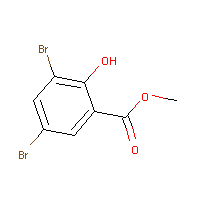

In [75]:
draw_mol_by_smiles('COC(=O)c1cc(Br)cc(Br)c1O')

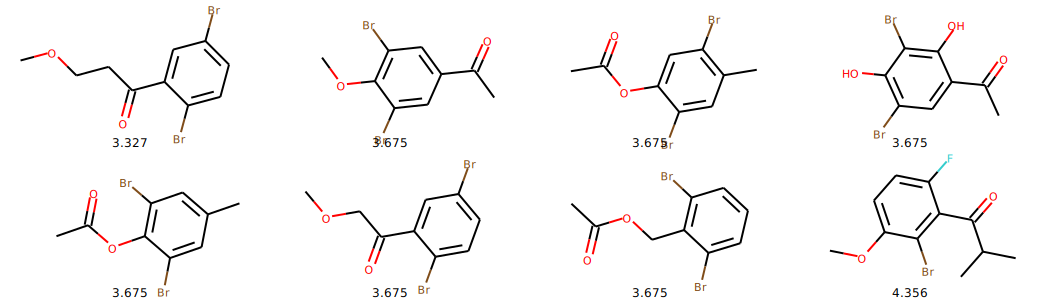

In [76]:
draw_multiple_mol(smiles_list=nn3['smiles'], legends=[str('{:.3f}'.format(i)) for i in nn3['dis']])

In [150]:
print_closest_words(x_embedding=x_embedding2, x_query='CCOC(=O)COc1ccc(Br)cc1', add_vec=ch2)

CCC(=O)c1cc(Br)c(OC)cc1O [0.59857804]
COc1ccc(C(=O)CCO)cc1Br [0.59857804]
O=C(CO)CCOc1ccccc1Br [0.59857804]
O=C(CO)CCOc1cccc(Br)c1 [0.59857804]
O=C(CO)CCOc1ccc(Br)cc1 [0.59857804]


In [151]:
print_closest_words(x_embedding=x_embedding2, x_query='O=C(OCC1CCCO1)c1cccc(Br)c1')

O=C(OCC1CCCO1)c1ccccc1Br [1.1920929e-07]
CCOC(=O)C1COc2ccc(Br)cc21 [1.1920929e-07]
O=C(Cc1cccc(Br)c1)OC1CCOC1 [1.1920929e-07]
CCOC(=O)C1Cc2cccc(Br)c2O1 [1.1920929e-07]
O=C(COCC1CCOC1)c1ccc(Br)cc1 [0.30967838]


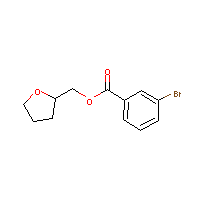

In [152]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1cccc(Br)c1')

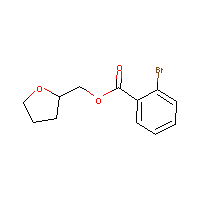

In [153]:
draw_mol_by_smiles('O=C(OCC1CCCO1)c1ccccc1Br')

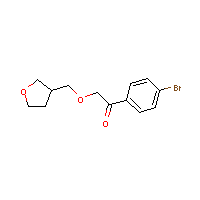

In [154]:
draw_mol_by_smiles('O=C(COCC1CCOC1)c1ccc(Br)cc1')

In [77]:
o = get_minus_result(x_embedding=x_embedding2, x='O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12', y='O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12')
o

array([[ 7.3909760e-06, -1.8835068e-05, -8.8549852e-02,  6.6950881e-01,
        -2.7281532e+00, -1.1626420e+00, -6.9843292e-02, -1.4876175e-01,
        -1.6943216e-03, -6.6462994e-01, -2.9093475e+00, -4.0628204e+00,
        -8.9672899e-01, -1.5974045e-03,  1.0409117e-01,  1.6149712e-01,
        -9.6040249e-02,  0.0000000e+00,  2.1350145e-01, -6.4856875e-01,
         0.0000000e+00,  5.2968979e-02, -5.2606010e-01, -1.4146066e-01,
         7.9092407e-01,  1.0371208e-05, -2.1745682e-02,  1.7037487e-01,
         3.9695501e-03, -1.1119280e+00]], dtype=float32)

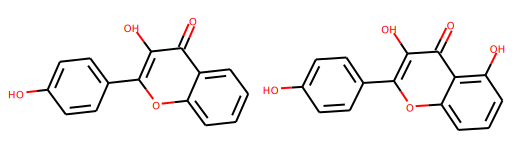

In [80]:
draw_multiple_mol(smiles_list=['O=c1c(O)c(-c2ccc(O)cc2)oc2ccccc12', 'O=c1c(O)c(-c2ccc(O)cc2)oc2cccc(O)c12'])

In [81]:
nn4 = print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=o, n=8)

Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1 [6.180429]
N#Cc1nc(Cc2ccccc2)oc1N1CCCC1 [6.180429]
Cc1ccccc1-c1nc(C#N)c(N2CCCC2)o1 [6.180429]
Cc1cccc(-c2nc(C#N)c(N3CCCC3)o2)c1 [6.180429]
Cc1cc(-c2ccco2)c(C#N)c(N2CCCC2)n1 [8.212344]
N#CC(c1ccccc1)N1CCN(Cc2ccccc2)CC1 [9.78524]
N#Cc1ccc(N2CCCCC2c2cccnc2)o1 [9.930106]
N#Cc1cccc(CNCC(c2ccco2)N2CCCC2)c1 [10.026421]


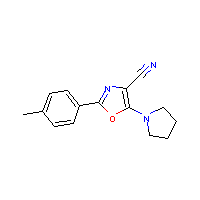

In [82]:
draw_mol_by_smiles('Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1')

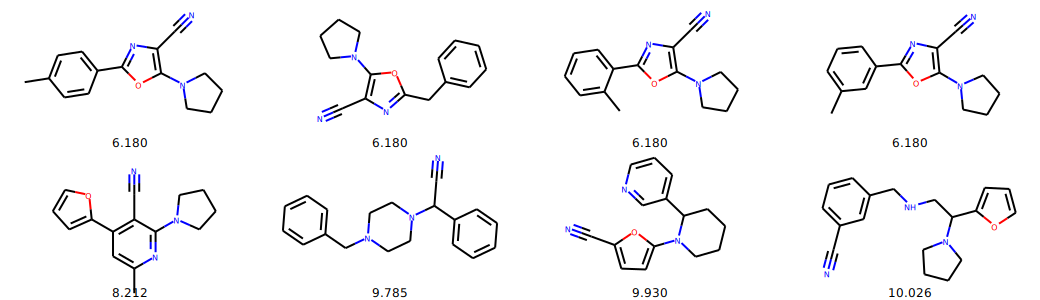

In [83]:
draw_multiple_mol(smiles_list=nn4['smiles'], legends=[str('{:.3f}'.format(i)) for i in nn4['dis']])

In [161]:
print_closest_words(x_embedding=x_embedding2, x_query='Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1', add_vec=ch2)

Cc1ccc(-c2nc(C#N)c(N3CCCC3)o2)cc1 [1.8267605]
N#Cc1nc(Cc2ccccc2)oc1N1CCCC1 [1.8267605]
Cc1ccccc1-c1nc(C#N)c(N2CCCC2)o1 [1.8267605]
Cc1cccc(-c2nc(C#N)c(N3CCCC3)o2)c1 [1.8267605]
N#Cc1nc(-c2ccccc2)oc1N1CCCCC1 [2.5910547]


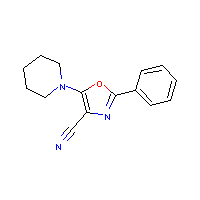

In [162]:
draw_mol_by_smiles('N#Cc1nc(-c2ccccc2)oc1N1CCCCC1')  # good example

##### similarity in fragment embedding

In [84]:
print_closest_words(x_embedding=frag2vec, x_query='CC')

C1=CC=CC=C1 [5.33924785]
CN [6.28932267]
C1=CCC=NC=C1 [6.91816561]
C1=CC=COC=C1 [6.92494981]
C1=CNCCC=N1 [6.96184878]


{'smiles': ['C1=CC=CC=C1',
  'CN',
  'C1=CCC=NC=C1',
  'C1=CC=COC=C1',
  'C1=CNCCC=N1'],
 'dis': [5.339247848950227,
  6.289322672437275,
  6.918165606767644,
  6.924949814309294,
  6.9618487833662295]}

In [85]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC')

C [4.3349195]
CN [5.66121]
CO [6.423283]
N [7.3686285]
C1=CC=CC=C1 [9.173969]


{'smiles': ['C', 'CN', 'CO', 'N', 'C1=CC=CC=C1'],
 'dis': [4.3349195, 5.66121, 6.423283, 7.3686285, 9.173969]}

In [86]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO')

C [5.2164626]
CC [6.423283]
CN [8.747613]
N [8.777768]
CCl [11.072725]


{'smiles': ['C', 'CC', 'CN', 'N', 'CCl'],
 'dis': [5.2164626, 6.423283, 8.747613, 8.777768, 11.072725]}

In [87]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C=C')

C=O [14.865458]
NS [17.158224]
S [17.161818]
N [17.30762]
C=S [17.351488]


{'smiles': ['C=O', 'NS', 'S', 'N', 'C=S'],
 'dis': [14.865458, 17.158224, 17.161818, 17.30762, 17.351488]}

In [88]:
double_bond = get_minus_result(x_embedding=frag_embedding_df, x='C=C', y='CC')
double_bond

array([[-3.5866964e-01,  2.3126738e+00,  1.3486111e-01, -6.2290239e+00,
         1.1453566e+01,  4.1439891e-02,  4.7287929e-01, -3.0629516e-01,
         4.9721003e-03,  2.1029043e-01, -6.7608213e-01, -5.9691668e-03,
        -1.4373094e+00, -1.5193210e+00,  4.2060137e-01,  7.4396729e-02,
         2.0847955e+00, -2.5580335e-01,  1.7592869e+00, -5.1015515e+00,
        -1.2652438e+00, -7.7798605e-02,  6.9976687e-02, -2.9333982e+00,
         7.2664495e+00,  2.5538492e+00,  1.4685720e+00,  3.8811059e+00,
         2.2401690e-02, -7.1897990e-01]], dtype=float32)

In [89]:
double_bond2 = get_minus_result(x_embedding=frag_embedding_df, x='C=O', y='CO')
double_bond2

array([[-5.6857622e-01,  9.5729256e-01, -1.0634899e-02, -1.9719505e+00,
         1.2793415e+01,  1.9147646e-01,  6.9857597e-02, -8.9328676e-01,
        -5.3203106e-04,  2.2094822e-01, -3.5330484e+00, -2.4792397e-01,
         1.9475548e+00,  4.0063518e-01,  5.2922845e-02,  5.0230026e-03,
         9.9584389e-01, -2.3538935e-01,  2.7515359e+00, -1.4891310e+00,
        -2.5767672e-01,  7.3638433e-01, -5.6399947e-01,  9.5924735e-02,
        -6.8078423e-01,  5.3163409e-02,  4.9984694e-02,  1.1466110e-01,
         1.8211484e-02, -1.7095435e-01]], dtype=float32)

In [90]:
double_bond3 = get_minus_result(x_embedding=frag_embedding_df, x='C=S', y='CS')
double_bond3

array([[ 6.1883759e-01,  5.6177053e+00,  1.1520028e-02, -1.6241407e-01,
         3.5491838e+00,  2.0313263e-04,  7.4039221e-02, -1.1759520e-02,
        -5.9792995e-03,  2.7089834e-01, -1.6454724e+00, -1.8172860e-02,
         9.4631696e-01,  2.1854005e+00, -1.5802383e-03,  1.6357660e-02,
         3.2828503e+00,  6.1988831e-02,  1.1105537e-03,  1.8470478e-01,
        -1.0588019e+00, -2.8457880e-02,  2.6285064e-01, -4.6593285e+00,
        -3.1698375e+00, -2.7437425e-01,  2.4198413e-02, -1.2915446e+00,
         3.7412643e-03,  1.8051932e+00]], dtype=float32)

In [91]:
double_bond4 = get_minus_result(x_embedding=frag_embedding_df, x='C=N', y='CN')
double_bond4

array([[-3.10368896e-01, -3.30581236e+00,  3.76058817e-02,
        -6.80397701e+00,  1.18225145e+01,  6.97910786e-03,
         6.56646490e-02, -7.84997821e-01, -1.50740147e-03,
         7.63778448e+00, -2.31906581e+00,  8.19742680e-03,
        -4.46847558e-01,  2.53318477e+00,  7.30024529e+00,
         4.44439459e+00, -1.14754725e+00, -2.74154425e-01,
        -2.82379389e-02, -2.23896837e+00, -2.64257908e+00,
        -2.23023057e-01,  1.24907315e-01, -3.86694860e+00,
        -6.49689198e+00, -1.43461347e-01,  4.09636140e-01,
         1.06292713e+00, -1.80292130e-02,  2.62832642e-03]], dtype=float32)

In [92]:
double_bond_mean = np.concatenate((double_bond, double_bond2, double_bond3, double_bond4)).mean(axis=0)
double_bond_mean

array([-1.5469429e-01,  1.3954648e+00,  4.3338031e-02, -3.7918413e+00,
        9.9046698e+00,  6.0024649e-02,  1.7061019e-01, -4.9908480e-01,
       -7.6165795e-04,  2.0849805e+00, -2.0434172e+00, -6.5967143e-02,
        2.5242871e-01,  8.9997488e-01,  1.9430473e+00,  1.1350430e+00,
        1.3039856e+00, -1.7583957e-01,  1.1209239e+00, -2.1612365e+00,
       -1.3060753e+00,  1.0177620e-01, -2.6566207e-02, -2.8409376e+00,
       -7.7026606e-01,  5.4729426e-01,  4.8809782e-01,  9.4178748e-01,
        6.5813065e-03,  2.2947182e-01], dtype=float32)

In [93]:
cal_distance(double_bond, double_bond3)

array([[17.88068]], dtype=float32)

In [94]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CC', add_vec=double_bond2)

C=O [6.423283]
C=C [12.5794325]
C=S [12.936846]
O=S [14.014361]
NS [14.050284]


{'smiles': ['C=O', 'C=C', 'C=S', 'O=S', 'NS'],
 'dis': [6.423283, 12.5794325, 12.936846, 14.014361, 14.050284]}

In [95]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CO', add_vec=double_bond2)

C=O [0.]
CO [14.087988]
O=S [14.105947]
C=S [14.306872]
C=C [14.865458]


{'smiles': ['C=O', 'CO', 'O=S', 'C=S', 'C=C'],
 'dis': [0.0, 14.087988, 14.105947, 14.306872, 14.865458]}

In [96]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CS', add_vec=double_bond2)

O=S [11.20353]
NS [12.316973]
OS [12.870725]
C=O [13.065614]
C=S [13.148287]


{'smiles': ['O=S', 'NS', 'OS', 'C=O', 'C=S'],
 'dis': [11.20353, 12.316973, 12.870725, 13.065614, 13.148287]}

In [97]:
print_closest_words(x_embedding=frag_embedding_df, x_query='OS', add_vec=double_bond_mean)

OS [12.194966]
C=O [19.651686]
C=N [21.66732]
O=S [22.462526]
C=S [23.162987]


{'smiles': ['OS', 'C=O', 'C=N', 'O=S', 'C=S'],
 'dis': [12.194966, 19.651686, 21.66732, 22.462526, 23.162987]}

In [98]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C1CC1', add_vec=double_bond)

C1CCCC1 [16.345669]
C1CCCCC1 [16.752832]
C1CC1 [17.36857]
C=C [17.56989]
C1CSCN1 [18.115517]


{'smiles': ['C1CCCC1', 'C1CCCCC1', 'C1CC1', 'C=C', 'C1CSCN1'],
 'dis': [16.345669, 16.752832, 17.36857, 17.56989, 18.115517]}

##### triple bond

In [99]:
tri_bond = get_minus_result(x_embedding=frag_embedding_df, x='C#C', y='CC')

In [100]:
# print_closest_words(x_embedding=frag_embedding_df, x_query=tri_bond)

In [101]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CN', add_vec=tri_bond)

C#C [5.66121]
C#N [9.315055]
C1=C[NH]C=C1 [13.571103]
C [13.663936]
CC [13.76328]


{'smiles': ['C#C', 'C#N', 'C1=C[NH]C=C1', 'C', 'CC'],
 'dis': [5.66121, 9.315055, 13.571103, 13.663936, 13.76328]}

In [102]:
print_closest_words(x_embedding=frag_embedding_df, x_query='CN')

CC [5.66121]
C [6.685929]
CO [8.747613]
C1=C[NH]C=C1 [9.620335]
C1=CCNC=C1 [10.059315]


{'smiles': ['CC', 'C', 'CO', 'C1=C[NH]C=C1', 'C1=CCNC=C1'],
 'dis': [5.66121, 6.685929, 8.747613, 9.620335, 10.059315]}

##### aromaticity, 芳香性

In [103]:
arom = get_minus_result(x_embedding=frag_embedding_df, x='C1=CC=CC=C1', y='C1CCCCC1')

In [104]:
print_closest_words(x_embedding=frag_embedding_df, x_query='C1CCOCC1', add_vec=arom)

C1=COC=C1 [14.51282]
C [14.600959]
C1=CC=COC=C1 [14.655043]
C1=CC=CC=C1 [14.73472]
CC [14.829526]


{'smiles': ['C1=COC=C1', 'C', 'C1=CC=COC=C1', 'C1=CC=CC=C1', 'CC'],
 'dis': [14.51282, 14.600959, 14.655043, 14.73472, 14.829526]}

In [35]:
with open('./figures/two_mol.svg', 'w') as f_handle:
    f_handle.write(img.data)

In [22]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

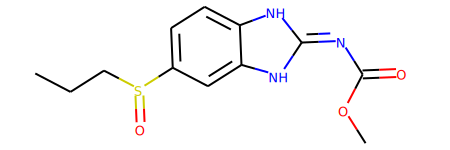

In [23]:
svg = moltosvg(mol=mols[0])
SVG(svg)

In [25]:
type(svg)

str